<a href="https://colab.research.google.com/github/RaoSiddhant/SIT796_RL/blob/main/Task_3_2_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#Importing Relevant Packages for the Environment Setup
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np

CAMPUS_MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]

class Univ_Camp_Bus(discrete.DiscreteEnv):
    
    def __init__(self):
        self.desc = np.asarray(CAMPUS_MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside bus
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            bus_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and bus_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # batch of students not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (bus_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (bus_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(bus_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, bus_row, bus_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = bus_row
        i *= 5
        i += bus_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def np_random(seed=None):
      if seed is not None and not (isinstance(seed, int) and 0 <= seed):
        raise error.Error('Seed must be a non-negative integer or omitted, not {}'.format(seed))

      seed = create_seed(seed)

      rng = np.random.RandomState()
      rng.seed(_int_list_from_bigint(hash_seed(seed)))
      return rng, seed

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        bus_row, bus_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                out[1 + bus_row][2 * bus_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # Batch of students in bus
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                ul(out[1 + bus_row][2 * bus_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


  


In [24]:
#EXACT POLICY ITERATION FOR MDP's For our evironment as per task 1.1 and 1.2 
#Importing Relevant Packages 

import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep
import warnings
warnings.filterwarnings('ignore')


#Calling the environment and showing the numer of States, Actions and Transition Probabilities, nexte state and rewards for each State-Action Pair
env = Univ_Camp_Bus()
env.reset()

print('Number of States for our Environment are:',env.observation_space.n)
print('Number of Actions for our Environment are:',env.action_space.n)
print('\nThe transition probabilities,next state, rewards and Reset(T/F) for each State-Action Pair is shown below:\n', env.P)

Number of States for our Environment are: 500
Number of Actions for our Environment are: 6

The transition probabilities,next state, rewards and Reset(T/F) for each State-Action Pair is shown below:
 {0: {0: [(1.0, 100, -1, False)], 1: [(1.0, 0, -1, False)], 2: [(1.0, 20, -1, False)], 3: [(1.0, 0, -1, False)], 4: [(1.0, 16, -1, False)], 5: [(1.0, 0, -10, False)]}, 1: {0: [(1.0, 101, -1, False)], 1: [(1.0, 1, -1, False)], 2: [(1.0, 21, -1, False)], 3: [(1.0, 1, -1, False)], 4: [(1.0, 17, -1, False)], 5: [(1.0, 1, -10, False)]}, 2: {0: [(1.0, 102, -1, False)], 1: [(1.0, 2, -1, False)], 2: [(1.0, 22, -1, False)], 3: [(1.0, 2, -1, False)], 4: [(1.0, 18, -1, False)], 5: [(1.0, 2, -10, False)]}, 3: {0: [(1.0, 103, -1, False)], 1: [(1.0, 3, -1, False)], 2: [(1.0, 23, -1, False)], 3: [(1.0, 3, -1, False)], 4: [(1.0, 19, -1, False)], 5: [(1.0, 3, -10, False)]}, 4: {0: [(1.0, 104, -1, False)], 1: [(1.0, 4, -1, False)], 2: [(1.0, 24, -1, False)], 3: [(1.0, 4, -1, False)], 4: [(1.0, 4, -10, False)

In [25]:
 #I have mounted on my drive and alraedy run this command
 from google.colab import drive
 import sys
 drive.mount('/content/drive', force_remount=True)
 sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
 import mdp

Mounted at /content/drive


###WE VISAULIZE AND UNDERSTAND USING 3 STATES (0,1 AND 16) AND FOR ALL 6 ACTIONS FOR THESE 3 STATES, INSTEAD OF ALL 500*6 STATE-ACTION PAIRS###

initial state = 0
next_state = 0, reward = 0.0, done = False
mdp.get_all_states = ('0', '1', '16')
mdp.get_possible_actions('1') =  ('0', '1', '2', '3', '4', '5')
mdp.get_next_states('1', '0') =  {'101': 1}
mdp.get_reward('1', '0', '0') =  0.0
mdp.get_transition_prob('1', '0', '0') =  0.0
Graphviz available: True


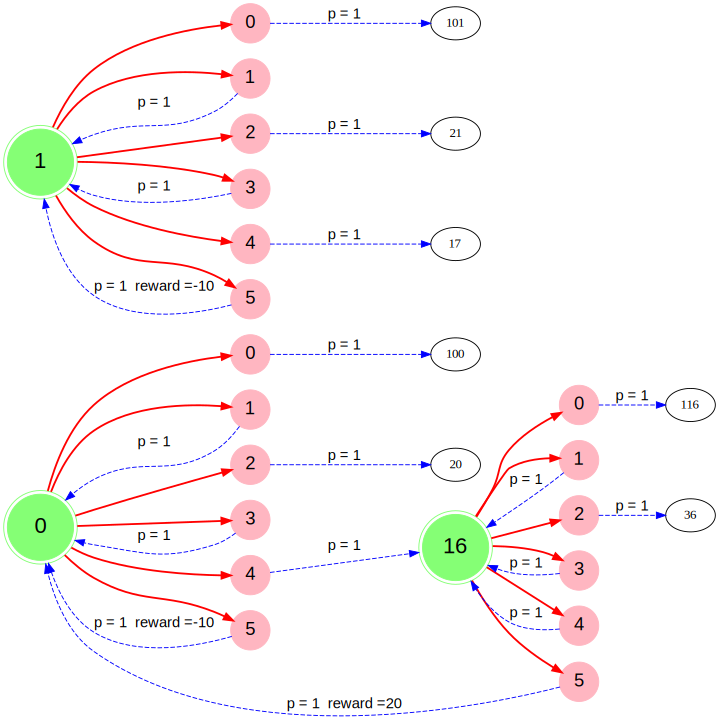

In [26]:
#WE SHOW THE VISUALIZATION FOR STATES 0,1 AND 16 FOR ALL 6 ACTIONS FOR EACH OF THESE STATES, THEIR TRANSITION PROBABILITIES, REWARDS AND NEXT STATES
#We use the same code from the practical and tweak it according to our environment for visualization
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  # Insert the directoryimport sys
  # Run the scripts
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

#WE SHOW THE VISUALIZATION FOR STATES 0,1 AND 16 FOR ALL 6 ACTIONS FOR EACH OF THESE STATES, THEIR TRANSITION PROBABILITIES, REWARDS AND NEXT STATES
#It does not make sense to show all 500 cases and corresponding actions, so we show 3 states and visaulize them. All connections will be made if we show the visaulaization for
#all state action pairs
#We observe that for state 16 if action 5 is chosen, then the reward is +20, transition probability is 1 and we reach a next state which is state 0

#Assigning the transition probabilities we get for our environment and storing in a dictionary
transition_probs = {
    '0': {
        '0': {'100': 1},
        '1': {'0': 1},
        '2': {'20': 1},
        '3': {'0': 1},
        '4': {'16': 1},
        '5': {'0': 1}
    },
    '1': {
        '0': {'101': 1},
        '1': {'1': 1},
        '2': {'21': 1},
        '3': {'1': 1},
        '4': {'17': 1},
        '5': {'1': 1}
    },
    '16': {
        '0': {'116': 1},
        '1': {'16': 1},
        '2': {'36': 1},
        '3': {'16': 1},
        '4': {'16': 1},
        '5': {'0': 1}
    }
}

#Storing Rewards in a dictionary
rewards = {
    '0': {'0': {'100': -1}},
    '0': {'1': {'0': -1}},
    '0': {'2': {'20': -1}},
    '0': {'3': {'0': -1}},
    '0': {'4': {'16': -1}},
    '0': {'5': {'0': -10}},
    '1': {'0': {'101': -1}},
    '1': {'1': {'1': -1}},
    '1': {'2': {'21': -1}},
    '1': {'3': {'1': -1}},
    '1': {'4': {'17': -1}},
    '1': {'5': {'1': -10}},
    '16': {'0': {'116': -1}},
    '16': {'1': {'16': -1}},
    '16': {'2': {'36': -1}},
    '16': {'3': {'16': -1}},
    '16': {'4': {'16': -10}},
    '16': {'5': {'0': 20}}
}

# We use the code from the practical and show the plot
from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='0')

print('###WE VISAULIZE AND UNDERSTAND USING 3 STATES (0,1 AND 16) AND FOR ALL 6 ACTIONS FOR THESE 3 STATES, INSTEAD OF ALL 500*6 STATE-ACTION PAIRS###\n')
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))


print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('1') = ", mdp.get_possible_actions('1'))
print("mdp.get_next_states('1', '0') = ", mdp.get_next_states('1', '0'))
print("mdp.get_reward('1', '0', '0') = ", mdp.get_reward('1', '0', '0'))
print("mdp.get_transition_prob('1', '0', '0') = ", mdp.get_transition_prob('1', '0', '0'))

from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

In [27]:
# Here we first define the policy evaluation step whcih is step 2 of the policy iteration method 
# In this step, we Evaluate a policy given an environment and a full description of the environment's dynamics
# We first initialize the value function to all zeros which is step 1 of policy iteration process
# The arguments it takes are 
#policy: which is a matrix of state and actin pairs. Includes the transition probabilities, next state, reward and done in list of transition tuples. 
#env.nS and env.nA are the number of states and actions in the environment. We have shown this before as well
#theta: We stop evaluation if the value function change is less than theta for all states
#discount_factor: Gamma or the discount factor
#It returns a Vector of length env.nS representing the value function  

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):

    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

#This is the third step fo the policy iteration called the policy improvement step where we try to improve on the existing policy. 
#It takes the following arguments:
#Our environment
#The policy from the policy evaluation step. We have provided its arguments before
#Gamma disount factor 
#It returns the optimal policy and the Value function of the optimal policy in the form of a Tuple



def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):

  #The one_step_lookahead function takes the state to consider and the value to use as an estimator as arguments to return
  #a vector of length env.nA containing the expected value of each action 

    def one_step_lookahead(state, V):

        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA

    while True:
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.nA)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
    
    return policy, np.zeros(env.nS)



In [28]:
#We initialize with a random policy and then move to the policy evaluation step 
env = Univ_Camp_Bus()
random_policy = np.ones([env.nS, env.nA]) / env.nA
#The State Values for all 500 states
print('The state values for each state is shown below:\n')
policy_eval(random_policy,env,discount_factor=0.95)

The state values for each state is shown below:



array([-66.26438752, -71.80792647, -71.42078771, -71.82385699,
       -79.85874125, -79.76644406, -79.85914609, -79.85320521,
       -78.94845049, -78.98965515, -78.18067178, -78.9907127 ,
       -79.89007096, -79.88569714, -79.8903011 , -79.81473063,
       -58.97388718, -71.28332886, -70.42368566, -71.3187026 ,
       -71.76849805, -75.09061994, -74.85861632, -75.10016676,
       -79.84505188, -79.74379722, -79.84549601, -79.83897851,
       -79.0763058 , -79.11250001, -78.40188794, -79.11342896,
       -79.87942213, -79.87462379, -79.87967461, -79.79676993,
       -67.0351757 , -74.29222689, -73.47645597, -74.33919453,
       -79.64432128, -79.7878237 , -79.77780243, -79.78823608,
       -77.71728288, -76.22431024, -77.72383134, -77.6277274 ,
       -79.84088218, -79.84711324, -79.72477359, -79.84727316,
       -79.40240042, -79.37859483, -79.40365295, -78.99236538,
       -76.72709833, -73.48229756, -76.82709925, -76.20673132,
       -79.71298147, -79.82877523, -79.82068901, -79.82

In [29]:
#Finding the optimal policy
pol_iter_policy = policy_improvement(env,policy_eval,discount_factor=0.99)
print('The optimal policy chosen as per policy iteration is:\n',pol_iter_policy[0])

The optimal policy chosen as per policy iteration is:
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


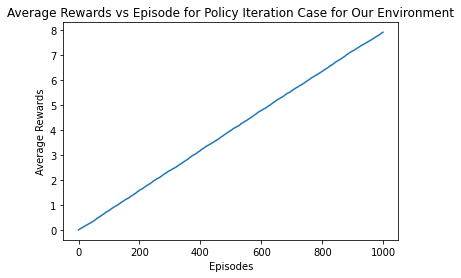

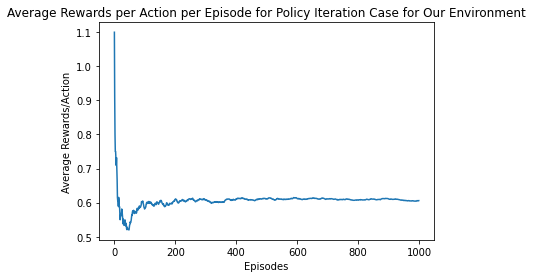

The Total Rewards for all 1000 episodes are:  7923
The Average Rewards for all 1000 episodes are:  7.923


In [30]:
#We finally 
def play_episodes(environment, n_episodes, policy):
        count = 0
        total_reward = 0
        avg_rew=[]
        rew_per_cnt=[]
        for episode in range(n_episodes):
          terminated = False
          state = environment.reset()
          while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(policy[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)
            # Summarize total reward
            count+=1
            
            total_reward += reward
            reward_per_count = total_reward/count
                                                
            # Update current state
            state = next_state
          
          avg_rew.append(total_reward/n_episodes) 
          rew_per_cnt.append(reward_per_count)          
                        
        average_reward = total_reward / n_episodes
        plt.plot(avg_rew)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.title('Average Rewards vs Episode for Policy Iteration Case for Our Environment')
        plt.show()
        plt.plot(rew_per_cnt)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards/Action')
        plt.title('Average Rewards per Action per Episode for Policy Iteration Case for Our Environment')
        plt.show()
        return total_reward, average_reward

# Number of episodes. We keep it to 1000 as per the question
n_episodes = 1000

# Call the chosen environment
environment = Univ_Camp_Bus()
# Search for an optimal policy using policy iteration
policy = pol_iter_policy[0]
# Apply best policy to the real environment
total_reward, average_reward = play_episodes(environment, n_episodes, policy)
print('The Total Rewards for all 1000 episodes are: ',total_reward)
print('The Average Rewards for all 1000 episodes are: ',average_reward)